# Imports

In [24]:
from transformers import pipeline 
import requests
from datetime import datetime, timedelta
import feedparser
from bs4 import BeautifulSoup
import numpy as np

# Collect Data

In [76]:
# Move to constants file later on
rss_url_list=[ 
  "https://moxie.foxnews.com/google-publisher/world.xml",
  "https://moxie.foxnews.com/google-publisher/politics.xml",
  "https://moxie.foxnews.com/google-publisher/science.xml",
  "https://moxie.foxnews.com/google-publisher/health.xml",
  "https://moxie.foxnews.com/google-publisher/sports.xml",
  "https://moxie.foxnews.com/google-publisher/travel.xml",
  "https://moxie.foxnews.com/google-publisher/tech.xml",
  ]

In [77]:
# Function to fetch articles from News RSS Feed
def fetch_news_articles(feed_url):
    articles = []
    feed = feedparser.parse(feed_url)
    for entry in feed.entries:
        try:
            content = entry.content[0].value
        except (KeyError, AttributeError):
            # content = None
            continue
        
        articles.append({
            'title': entry.title,
            'description': entry.description,
            'content': content
        })

    return articles

# Iterate over all rss urls
articles = []
for url in rss_url_list:
    articles += fetch_news_articles(url)


In [78]:
print('Number of articles',len(articles))
articles[0:5]

Number of articles 174


[{'title': 'Tourist defaces ancient Roman wall on vacation, angering Italian authorities',
  'description': 'A 27-year-old man from the Netherlands got into hot water with Italian authorities after he allegedly wrote his graffiti signature on an ancient wall in Herculaneum.',
  'content': '<p>A young man from the Netherlands was reprimanded by Italian police after he allegedly vandalized a historic Roman wall while on holiday.</p><p>The incident took place in Herculaneum, an Ancient Roman town that – like Pompeii – was covered in volcanic ash from the <a href="https://www.foxnews.com/category/science/archaeology/history" rel="noopener" target="_blank">eruption of Mount Vesuvius</a> in 79 AD.</p><p>In a press release published Monday, the Carabinieri, an Italian law enforcement agency, explained that the tourist "signed" the walls of a <i>domus </i>in the town on Sunday night. A <i>domus </i>was a townhouse-like residence for families in antiquity.</p><p>The 27-year-old was <a href="htt

# Preprocessing

In [79]:
# Iterate over dictionary items and remove HTML tags from each value
cleaned_articles = [{key: BeautifulSoup(value, "html.parser").get_text() for key, value in article.items()} for article in articles]

C:\Users\h4has\AppData\Local\Temp\ipykernel_26404\2471284376.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  cleaned_articles = [{key: BeautifulSoup(value, "html.parser").get_text() for key, value in article.items()} for article in articles]


In [80]:
cleaned_articles[:5]

[{'title': 'Tourist defaces ancient Roman wall on vacation, angering Italian authorities',
  'description': 'A 27-year-old man from the Netherlands got into hot water with Italian authorities after he allegedly wrote his graffiti signature on an ancient wall in Herculaneum.',
  'content': 'A young man from the Netherlands was reprimanded by Italian police after he allegedly vandalized a historic Roman wall while on holiday.The incident took place in Herculaneum, an Ancient Roman town that – like Pompeii – was covered in volcanic ash from the eruption of Mount Vesuvius in 79 AD.In a press release published Monday, the Carabinieri, an Italian law enforcement agency, explained that the tourist "signed" the walls of a domus in the town on Sunday night. A domus was a townhouse-like residence for families in antiquity.The 27-year-old was touring southern Italy on vacation at the time.ANCIENT ROMAN WALL PAINTING DOES NOT DEPICT PIZZA AFTER ALL, ARCHEOLOGISTS SAY"A 27-year-old Dutchman, on hol

# Export to Database

# Fine Tune T-5 Small model

We will fine-tune the T5-small model. At the Overview page of the Hugging Face T5 model, it provides the following tips:

T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format.
T5 works well on a variety of tasks out-of-the-box by prepending a different prefix to the input corresponding to each task, e.g., for translation: translate English to German: …, for summarization: summarize: ….

In [11]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq,AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments,Seq2SeqTrainer
from datasets import Dataset

### Load news summary dataset 

Ref: https://www.kaggle.com/datasets/pariza/bbc-news-summary

In [12]:
import os
import pandas as pd

def load_dataset(articles_dir, summaries_dir):
    data = {'article': [], 'summary': []}
    
    for category in os.listdir(articles_dir):
        category_articles_dir = os.path.join(articles_dir, category)
        category_summaries_dir = os.path.join(summaries_dir, category)
        
        for filename in os.listdir(category_articles_dir):
            article_path = os.path.join(category_articles_dir, filename)
            summary_path = os.path.join(category_summaries_dir, filename)
            
            with open(article_path, 'r') as file:
                article = file.read()
                
            with open(summary_path, 'r') as file:
                summary = file.read()
                
            data['article'].append(article)
            data['summary'].append(summary)
    
    return pd.DataFrame(data)

# Load the dataset
articles_dir = 'BBC News Summary/News Articles'
summaries_dir = 'BBC News Summary/Summaries'
news_dataset = load_dataset(articles_dir, summaries_dir)

In [13]:

# Convert the DataFrame to a HuggingFace Dataset
dataset = Dataset.from_pandas(news_dataset) 
dataset

Dataset({
    features: ['article', 'summary'],
    num_rows: 500
})

In [14]:
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'summary'],
        num_rows: 400
    })
    test: Dataset({
        features: ['article', 'summary'],
        num_rows: 100
    })
})

In [15]:
# Initialize the tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples["article"], examples["summary"], padding="longest", truncation=True )

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

c:\Users\h4has\anaconda3\envs\headlines\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map:   0%|          | 0/400 [00:00<?, ? examples/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if 

### Tokenize

Red: https://github.com/anyuanay/medium/blob/main/src/working_huggingface/Working_with_HuggingFace_ch3_Fine_Tuning_T5_Small_Text_Summarization_Model.ipynb?source=post_page-----3d48eb3c4360--------------------------------


We will create a function to preprocess the training and test data in batch. The preprocessing function will perform the following actions:

Prepend the prefix "summarize: " to each text document to indicate to the T5 model that the task at hand is summarization.
Convert the input texts and summary labels into a tokenized format that can be processed by the T5 model.
Set the max_length parameter to ensure that the tokenized inputs and labels do not exceed a certain length, truncating any text that is too long.
Assign the tokenized labels to the labels field of model_inputs, which will be used during training to calculate the loss and optimize the model's parameters.

In [16]:
def preprocess_function(examples):
    # Prepends the string "summarize: " to each document in the 'text' field of the input examples.
    # This is done to instruct the T5 model on the task it needs to perform, which in this case is summarization.
    inputs = ["summarize: " + doc for doc in examples["article"]]

    # Tokenizes the prepended input texts to convert them into a format that can be fed into the T5 model.
    # Sets a maximum token length of 1024, and truncates any text longer than this limit.
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    # Tokenizes the 'summary' field of the input examples to prepare the target labels for the summarization task.
    # Sets a maximum token length of 128, and truncates any text longer than this limit.
    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True)

    # Assigns the tokenized labels to the 'labels' field of model_inputs.
    # The 'labels' field is used during training to calculate the loss and guide model learning.
    model_inputs["labels"] = labels["input_ids"]

    # Returns the prepared inputs and labels as a single dictionary, ready for training.
    return model_inputs

In [17]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 100/100 [00:00<00:00, 285.33 examples/s]


In [18]:
tokenized_dataset['test'][0]['article']

'UK plan to deport terror suspects\n\nDeals are being sought to allow the UK to deport terror suspects to their home countries without risk of them being tortured or sentenced to death.\n\nHome Secretary Charles Clarke told the Times he hoped agreement with several countries could be reached. The move follows a Law Lords judgement that the detention of 12 men at Belmarsh prison, London, and Woodhill, Milton Keynes, was unlawful. The 12 affected by the ruling are from Algeria, Tunisia, Egypt and Jordan. The government was told that using anti-terror legislation brought in after 11 September to hold the men indefinitely without charge broke human rights laws.\n\nMr Clarke told The Times: "I think we should be prosecuting much more energetically our ability to deport the individuals concerned to the countries from which they come." He said it was a route that was being pursued in collaboration with Foreign Secretary Jack Straw "in a very positive way". Mr Clarke said that he was seeking "

### Define a Compute metric

In [19]:
import evaluate

rouge = evaluate.load("rouge")

Create a function that passes the predictions and labels to calculate the ROUGE metric as follows:

The eval_pred tuple is unpacked into predictions and labels.
The tokenizer.batch_decode method is used to decode the tokenized predictions and labels back to text, skipping any special tokens like padding tokens.
The np.where function is used to replace any instances of -100 in the labels array with the tokenizer's pad_token_id, as -100 is often used to signify tokens that should be ignored during loss calculation.
The rouge.compute method is called to calculate the ROUGE metric between the predictions and labels, which is a common metric for evaluating text summarization performance.
The length of each prediction is calculated by counting the number of non-padding tokens, and the mean prediction length is added to the result dictionary under the key "gen_len".
Finally, the values in the result dictionary are rounded to 4 decimal places for cleaner output, and the result is returned.

In [20]:
def compute_metrics(eval_pred):
    # Unpacks the evaluation predictions tuple into predictions and labels.
    predictions, labels = eval_pred

    # Decodes the tokenized predictions back to text, skipping any special tokens (e.g., padding tokens).
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replaces any -100 values in labels with the tokenizer's pad_token_id.
    # This is done because -100 is often used to ignore certain tokens when calculating the loss during training.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decodes the tokenized labels back to text, skipping any special tokens (e.g., padding tokens).
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Computes the ROUGE metric between the decoded predictions and decoded labels.
    # The use_stemmer parameter enables stemming, which reduces words to their root form before comparison.
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Calculates the length of each prediction by counting the non-padding tokens.
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]

    # Computes the mean length of the predictions and adds it to the result dictionary under the key "gen_len".
    result["gen_len"] = np.mean(prediction_lens)

    # Rounds each value in the result dictionary to 4 decimal places for cleaner output, and returns the result.
    return {k: round(v, 4) for k, v in result.items()}


### Train model

In [21]:
from transformers import DataCollatorForSeq2Seq

model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="t5-small")

# Define the training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="my_fine_tuned_t5_small_model",
    evaluation_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=True,
)


# Initialize the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
# Batch size 8 LR 5e-4
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,0.265960,0.208300,0.158000,0.195000,0.195600,19.000000
2,No log,0.238664,0.220800,0.175300,0.207000,0.207300,19.000000
3,No log,0.226535,0.228700,0.186900,0.218100,0.218200,19.000000
4,No log,0.226045,0.237000,0.201700,0.228100,0.228000,19.000000
5,No log,0.225981,0.237600,0.204100,0.229600,0.229300,19.000000
6,No log,0.229983,0.244600,0.214400,0.238000,0.238400,19.000000
7,No log,0.233475,0.247800,0.217800,0.241500,0.241400,19.000000
8,No log,0.238451,0.251400,0.223800,0.245900,0.246400,19.000000
9,No log,0.234091,0.252000,0.222800,0.246400,0.246300,19.000000
10,0.215000,0.235176,0.250400,0.221600,0.244700,0.244700,19.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=500, training_loss=0.21499803161621095, metrics={'train_runtime': 291.8696, 'train_samples_per_second': 13.705, 'train_steps_per_second': 1.713, 'total_flos': 864497871618048.0, 'train_loss': 0.21499803161621095, 'epoch': 10.0})

### Save the fine tuned model

In [ ]:
trainer.save_model("fine_tuned_t5_small_model")
torch.save(model.state_dict(), 'fine_tuned_t5_small_model/pytorch_model.bin')

### Load the model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load tokenizer and model 
model = AutoModelForSeq2SeqLM.from_pretrained("fine_tuned_t5_small_model")
tokenizer = AutoTokenizer.from_pretrained('fine_tuned_t5_small_model')

# Story Clustering

### Tokenize and Vectorize

In [81]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from transformers import pipeline
from sentence_transformers import SentenceTransformer

# Download necessary NLTK data
nltk.download('punkt')


# Preprocess the content
def preprocess(text):
    # Tokenization, lowercasing, removing punctuation, etc.
    tokens = nltk.word_tokenize(text.lower())
    return ' '.join(tokens)

preprocessed_articles = [preprocess(article['content']) for article in cleaned_articles]

# Vectorize the articles using BERT embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
X = model.encode(preprocessed_articles)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\h4has\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [82]:
print(X.shape)

(174, 384)


### K-means

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#### Silhoutte analysis

10


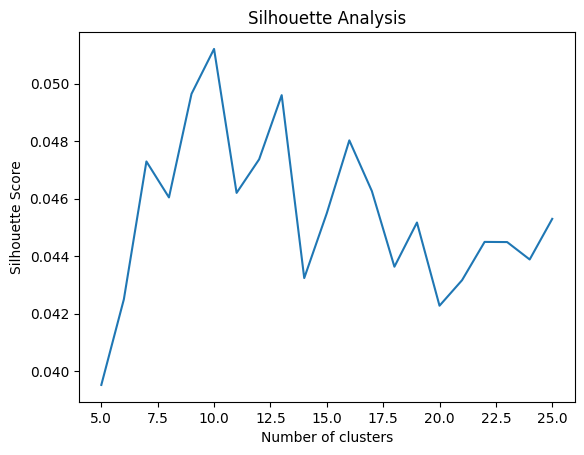

In [84]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

min_clusters = 5
max_clusters = 25
silhouette_scores = []
for i in range(min_clusters, max_clusters+1):
    kmeans = KMeans(n_clusters=i, init='k-means++',n_init=1, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

optimal_k = silhouette_scores.index(max(silhouette_scores)) + min_clusters
print(optimal_k)
plt.plot(range(5, max_clusters+1), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


In [86]:
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans.fit(X_scaled)

labels = kmeans.labels_
print(labels)


# Group articles by cluster
clusters = {i: [] for i in range(optimal_k)}
for idx, label in enumerate(labels):
    clusters[label].append(cleaned_articles[idx])

[3 3 4 3 1 1 9 1 1 4 1 3 1 3 3 1 3 3 6 1 1 4 3 3 1 1 4 1 4 4 6 2 4 4 6 4 4
 4 1 4 4 4 6 4 6 4 4 4 4 4 8 8 8 5 5 8 5 5 3 8 5 6 3 8 5 8 8 5 8 5 8 9 6 5
 5 6 6 7 6 6 6 5 6 3 6 6 7 3 6 6 6 6 6 6 6 6 6 6 5 6 2 2 2 2 2 7 2 7 2 7 2
 7 2 2 2 2 2 7 7 2 6 7 2 2 9 9 9 9 9 9 9 9 9 5 9 9 3 9 9 9 9 9 9 9 9 9 9 9
 9 0 9 0 3 0 0 4 5 0 3 0 9 0 1 0 0 9 4 3 9 9 0 0 0 0]


c:\Users\h4has\anaconda3\envs\headlines\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [87]:
for cluster,article in enumerate(clusters.values()):
  print('cluster ',cluster)
  for art in article:
    print(art)
  print(len(article))

cluster  0
{'title': 'Android banking trojan masquerades as Google Play to steal your data', 'description': 'New malware poses as a Google Play update with the intention of stealing data from Android users. Kurt “CyberGuy" Knutsson discusses how to protect yourself.', 'content': 'Criminals constantly develop new ways to scam people, and their latest tactic involves infecting Android phones with malware to access banking information and other details. Researchers at the cybersecurity firm Cyble have discovered a new malware, dubbed Antidot, which masquerades as a Google Play update application. It displays fake Google Play update pages in multiple languages and captures sensitive information.GET SECURITY ALERTS, EXPERT TIPS - SIGN UP FOR KURT’S NEWSLETTER - THE CYBERGUY REPORT HEREAs detailed by Cyble, Antidote is a Trojan – malware that misleads users of its true intent by disguising itself as a standard program. In this case, it impersonates the Google Play Store (the default app mark

#### Cluster Goodness Metrics

In [88]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

# Assuming you have your data in a variable `X`
# Fit the KMeans++ model
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Calculate the Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {davies_bouldin_avg}")

# Calculate the Calinski-Harabasz Index
calinski_harabasz_avg = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")

# Calculate Inertia
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")


c:\Users\h4has\anaconda3\envs\headlines\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.05070123448967934
Davies-Bouldin Index: 3.116388495298982
Calinski-Harabasz Index: 4.611240333485216
Inertia: 53836.7421875


# Summarize each cluster

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/pegasus-cnn_dailymail")
model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-cnn_dailymail")

# # Save tokenizer and model
# tokenizer.save_pretrained("pegasus_model")
# model.save_pretrained("pegasus_model")


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

from transformers import pipeline


# Load tokenizer and model from the saved directory
tokenizer = AutoTokenizer.from_pretrained("pegasus_model")
model = AutoModelForSeq2SeqLM.from_pretrained("pegasus_model")


In [94]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load pre-trained T5 model and tokenizer
model_name = "t5-small"
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)


c:\Users\h4has\anaconda3\envs\headlines\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [95]:
def summarize_content(content, max_length):
    """
    Summarizes a single content to the specified maximum length.

    Args:
    - content (str): The content to be summarized.
    - max_length (int): The maximum length of the summary.

    Returns:
    - The summarized content.
    """
    # Summarize the content
    inputs = tokenizer.encode("summarize: " + content, return_tensors="pt", max_length=max_length, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=int(0.75 * max_length), length_penalty=2.0, num_beams=4, early_stopping=True)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Check if the summary ends mid-sentence
    if not summary.endswith('.'):
        # Find the last full stop and cut the summary till that point
        last_full_stop_index = summary.rfind('.')
        if last_full_stop_index != -1:
            summary = summary[:last_full_stop_index + 1]  # Include the last full stop

    return summary

In [96]:
def summarize_cluster(cluster_texts, model_max_tokens = 2000): #7818):
    """
    Summarizes a cluster of texts by summarizing each individual text and concatenating the summaries.

    Args:
    - cluster_texts (list of dicts): List containing dictionaries with 'content' key for each news content in the cluster.

    Returns:
    - Summary of the concatenated news content within the cluster.
    """
    # Determine the maximum token limit per content
    max_token_limit_per_content = model_max_tokens // len(cluster_texts)

    # Summarize each content
    summarized_contents = []
    for text in cluster_texts:
        summarized_content = summarize_content(text['content'], max_token_limit_per_content)
        summarized_contents.append(summarized_content)

    # Concatenate the summarized contents
    cluster_summary = " ".join(summarized_contents)
    # print('Concated Summary', cluster_summary)

    # summarized_cluster = summarize_content(cluster_summary, model_max_tokens)
    # print('Cluster Summary', summarized_cluster)
    return cluster_summary

In [98]:
# Summarize each cluster
cluster_summaries = {}
for cluster_id, texts in clusters.items():
    summary = summarize_cluster(texts)
    cluster_summaries[cluster_id] = summary
    print(f"Cluster {cluster_id} Summary:")
    print(summary)

Cluster 0 Summary:
researchers at the cybersecurity firm Cyble have discovered a new malware, dubbed Antidot, which masquerades as a Google Play update application. it displays fake Google Play update pages in multiple languages and captures sensitive information. antidote is a malware that misleads users of a mobile phone to access banking information and other details. the malware is a Trojan that misleads users of a mobile phone. google's AI, named Gemini, was featured prominently at the I/O conference and is now available to developers worldwide. here are the seven biggest things we learned from Google at I/O 2024. google's AI, named Gemini, was featured prominently at the conference and is now available to developers worldwide. CLICK TO GET KURT’S KURT’S KURT’S KURT’s KURT’s KURT’s KURT’s. password sharing can be very convenient when visiting a new location or a family or friend's house. you can simply use password sharing to "drop" a password to your intended friend or family mem

# Export summaries to database

# Next

1. automate the search for best hyperparamters values (for eps and min_samples)  -- DBSCAN Not working well -- check for problem

1. K-means any way to optimize cluster paramanters?
  -- Identify if clusters are dense/sparese using some metric like Inertia, Silhouette Score, etc.

2. More preprocessing -- see if needed -- maybe once more data is added
  
  2.1 Remove punctuations -- wait is this really needed? ouncs might be needed for summarizer tools to work better.

3. More data sources
  
  3.1 Include more time frame -- maybe a whole week
  
  3.2 More data sources -- possibly RSS feeds
  
4. Display titles as summaries and maybe also as tags on the screen -- the user selects what tags they want to explore -- think about this

  4.1. So we first group similar news -- and then summarize the content (take care not to skip important details)
  
  4.2. We then create a tag/title(of 1-4 words) for this group

1. Maybe look for better/faster ways to work the tokenizer and vectors. Explore batch prcessing and other tokenizer techniques -- nltk or Transformers?

5. Deployment -- dk yet - maybe think of some AWS deployment

6. CI/CD -- not sure yet







